# 8. MNISTを使った数字認識

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

# warning表示off
import warnings
warnings.simplefilter('ignore')
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [3]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
#
# MNISTをダウンロードする
#

# ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = 'data/'

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,  
    # 訓練データか検証データか
    train = True,  
    # 元データがない場合にダウンロードするか
    download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
# データ件数の確認
print('データ件数: ', len(train_set0))

データ件数:  60000


In [7]:
# 最初の要素の取得
image, label = train_set0[0]

# データ型の確認
print('入力データの型: ', type(image))
print('正解データの型: ', type(label))

入力データの型:  <class 'PIL.Image.Image'>
正解データの型:  <class 'int'>


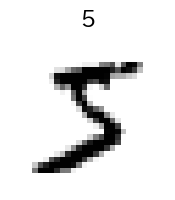

In [8]:
# 入力データの画像表示

plt.figure(figsize=(2,3))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

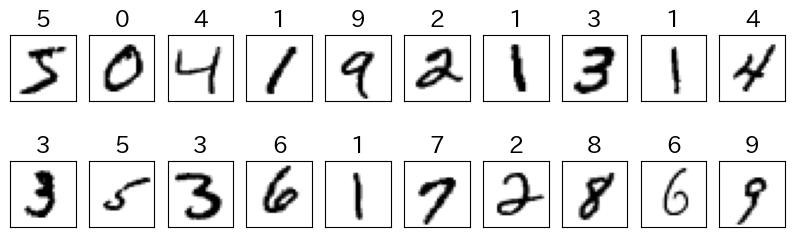

In [9]:
# 正解データ付きで、最初の20個をイメージ表示

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # image と labelの取得
    image, label = train_set0[i]
    
    # イメージ表示
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

- 学習データをモデルの入力にする前に加工する
    - `torchvision.transforms`に，前処理に便利な部品を揃っているので，これを組み合わせて使うだけで，簡単に望む形式にデータを変換することができる

In [11]:
from torchvision import transforms

# 入力データの形式をPytorchで扱えるテンソル形式に変換する機能
transforms1 = transforms.Compose([
    transforms.ToTensor()
])

train_set1 = datasets.MNIST(
    root = data_root,
    train=True,
    download=True,
    transform = transforms1,
)

# 変換結果の確認

image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [12]:
# 標準化
transform2 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    
    # データの正規化
    # [0,1]に正規化されているが，今回は[-1, 1]
    transforms.Normalize(0.5,  0.5),
])

train_set2 = datasets.MNIST(
    root = data_root,  train = True,  download = True,
    transform = transform2)

# 変換結果の確認

image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [13]:
transform3 = transforms.Compose([
    # データのTensor化
    transforms.ToTensor(),
    # データの正規化
    transforms.Normalize(0.5, 0.5),
    # Tensorの1階テンソル化
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,
    train = True,  
    download=True,
    transform = transform3)

# 変換結果の確認
image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [14]:
#
# 最終的な前処理コード
#

# データ変換用関数 Transforms
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),
    
    # (2) データの正規化
    transforms.Normalize(0.5, 0.5),
    
    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

In [15]:
# ライブラリインポート
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 500

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size, 
    shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  batch_size = batch_size, 
    shuffle = False) 

In [17]:
# 何組のデータが取得できるか
print(len(train_loader))
print(len(test_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

120
20
torch.Size([500, 784])
torch.Size([500])


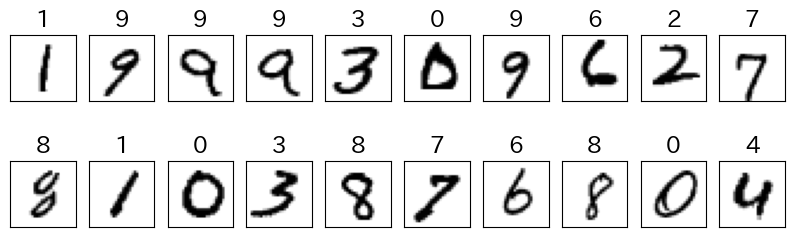

In [18]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # numpyに変換
    image = images[i].numpy()
    label = labels[i]
    
    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
# 
# モデルの定義
#

# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [20]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = 10

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')


# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden)

# モデルをGPU側に送る
net = net.to(device)

n_input: 784  n_hidden: 128 n_output: 10


In [21]:
#
# 最適化アルゴリズムと損失関数
#

# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

In [22]:
# モデル内のパラメータの確認
# l1.weight, l1.bias, l2.weight, l2.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [23]:
# モデルのサマリー表示

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

In [24]:
# 訓練データセット　最初の1項目を取得
# データローダーから最初の1セットを取得する
for images, labels in train_loader:
    break 

# データローダーから取得したデータをGPUに送る
inputs = images.to(device)
labels = labels.to(device)

# 予測計算
outputs = net(inputs)

# 結果確認
print(outputs)

tensor([[-0.3622, -0.1927, -0.0179,  ...,  0.1073,  0.1025, -0.0615],
        [-0.4072, -0.1814,  0.0716,  ...,  0.1866,  0.1975,  0.1161],
        [-0.3221, -0.0547, -0.2868,  ...,  0.1967, -0.0103,  0.1591],
        ...,
        [-0.2091, -0.1058,  0.2365,  ...,  0.1360,  0.0665,  0.0987],
        [-0.2756, -0.2012,  0.1703,  ...,  0.1223,  0.2388,  0.0233],
        [-0.3045, -0.2458,  0.1416,  ...,  0.1012,  0.0820, -0.1457]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


2.3328874111175537


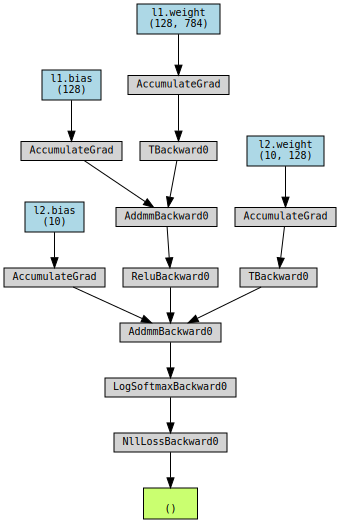

In [25]:
#  損失計算
loss = criterion(outputs, labels)

# 損失値の取得
print(loss.item())

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [26]:
# ...

In [ ]:
# 繰り返し計算

